# Выбор региона для разработки новых нефтяных месторождений

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


**Описание данных**

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

**Дополнение:**
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуем 500 точек, из которых с помощью машинного обучения выбирем 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### Импорт библиотек

In [93]:
# библиотеки работы с данными
import pandas as pd
import numpy as np

# откючаем предупреждения
import warnings
warnings.filterwarnings('ignore')

# графики
import matplotlib.pyplot as plt
import seaborn as sns

# обработка исключений для предупреждений pandas (без предупреждения, без исключения)
pd.options.mode.chained_assignment = None

# предобработка данных
from sklearn.preprocessing import StandardScaler # масштабирование
from sklearn.model_selection import train_test_split # разделение на выборки
from sklearn.utils import shuffle # перемешивание

# модель линейной регрессии
from sklearn.linear_model import LinearRegression

# метрики
from sklearn.metrics import mean_squared_error

# статистика
from scipy import stats as st

# печать всех команд одной ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Загрузка данных из файлов csv

#### Открываем файлы

In [94]:
df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')

#### Содержимое таблиц

In [95]:
print('Данные геологоразведки первого региона (df_1):')
df_1.head()
print('Данные геологоразведки второго региона (df_2):')
df_2.head()
print('Данные геологоразведки третьего региона (df_3):')
df_3.head()

Данные геологоразведки первого региона (df_1):


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Данные геологоразведки второго региона (df_2):


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Данные геологоразведки третьего региона (df_3):


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


#### Структура таблиц

In [96]:
print('df_1')
df_1.info()
print()

print('df_2')
df_2.info()
print()

print('df_3')
df_3.info()

df_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

df_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

df_3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)


#### Описательная статистика

In [97]:
print('df_1')
df_1.describe()
print()

print('df_2')
df_2.describe()
print()

print('df_3')
df_3.describe()

df_1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



df_2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



df_3


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### Исследуем столбец "id"

In [98]:
print('Количество дубликатов в столбце "id"')
print('в df_1:', df_1['id'].duplicated().sum())
print('в df_2:', df_2['id'].duplicated().sum())
print('в df_3:', df_3['id'].duplicated().sum())

Количество дубликатов в столбце "id"
в df_1: 10
в df_2: 4
в df_3: 4


Посмотрим на содержимое строк с посторяющимся id:

In [99]:
print('дубли по id в df_1:')
ids1 = df_1["id"]
df_1[ids1.isin(ids1[ids1.duplicated()])].sort_values("id")

print('дубли по id в df_2:')
ids2 = df_2["id"]
df_2[ids2.isin(ids2[ids2.duplicated()])].sort_values("id")

print('дубли по id в df_3:')
ids3 = df_3["id"]
df_3[ids3.isin(ids3[ids3.duplicated()])].sort_values("id")

дубли по id в df_1:


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


дубли по id в df_2:


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


дубли по id в df_3:


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Повторы в колонке идентификации 'id' можно объяснить тем, что пробы брались из скважины с повторяющимся id по несколько раз и каждый раз результаты были разными, поэтому дубликатами не являются и строки удалению не подлежат.

Из исходного массива данных можно удалить колонку идентификации, т.к. она может помешать построению модели и качественного предсказания.

In [100]:
df_1.drop('id', axis='columns', inplace=True)
df_2.drop('id', axis='columns', inplace=True)
df_3.drop('id', axis='columns', inplace=True)

df_1.columns
df_2.columns
df_3.columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

### Вывод

1. Каждая таблица содержит 10 тысяч строк, по каждому из трех регинонов, несущих информациию о пробах нефти из скважин и объеме запасов нефти в них
2. Пропусков в данных не обнаружено
3. Данные, представленные в столбцах, с учетом того, что мы о них знаем, корректны
4. В колонке id найдены дубликаты, которые не подлежат удалению из-за уникальности и ценности содержимого строк по ним
5. А вот сама колонка идентификации может негативно повлиять на адекватность будущих предсказаний, поэтому было решено избавиться от нее

## Обучение и проверка модели

### Разбиение датасета на обучающую и валидационную выборки
создаем таблицы с целевым признаком (target) и фичами (features) из исходной (по каждому региону)  

**Регион 1**

In [101]:
features1 = df_1.drop(['product'], axis=1)
target1 = df_1['product']

features1.shape
target1.shape

(100000, 3)

(100000,)

**Регион 2**

In [102]:
features2 = df_2.drop(['product'], axis=1)
target2 = df_2['product']

features2.shape
target2.shape

(100000, 3)

(100000,)

**Регион 3**

In [103]:
features3 = df_3.drop(['product'], axis=1)
target3 = df_3['product']

features3.shape
target3.shape

(100000, 3)

(100000,)

Произведём разбиение датасета с фичами (features) на 2 части: 
* тренировочный trainX (75%) 
* и валидационный validX (25%)   
по каждому региону  

Для этого в каждом случае объявим 4 переменные и запишем в них:
* признаки: features_trainX, features_validX
* целевой признак: target_trainX, target_validX

**Регион 1**

In [104]:
features_train1, features_valid1, target_train1, target_valid1 = \
        train_test_split(features1, target1, test_size=0.25, random_state=12345)

print('Размер features_train1', features_train1.shape)
print('Размер features_valid1', features_valid1.shape)
print('Размер target_train1', target_train1.shape)
print('Размер target_valid1', target_valid1.shape)

Размер features_train1 (75000, 3)
Размер features_valid1 (25000, 3)
Размер target_train1 (75000,)
Размер target_valid1 (25000,)


**Регион 2**

In [105]:
features_train2, features_valid2, target_train2, target_valid2 = \
        train_test_split(features2, target2, test_size=0.25, random_state=12345)

print('Размер features_train2', features_train2.shape)
print('Размер features_valid2', features_valid2.shape)
print('Размер target_train2', target_train2.shape)
print('Размер target_valid2', target_valid2.shape)

Размер features_train2 (75000, 3)
Размер features_valid2 (25000, 3)
Размер target_train2 (75000,)
Размер target_valid2 (25000,)


**Регион 3**

In [106]:
features_train3, features_valid3, target_train3, target_valid3 = \
        train_test_split(features3, target3, test_size=0.25, random_state=12345)

print('Размер features_train3', features_train3.shape)
print('Размер features_valid3', features_valid3.shape)
print('Размер target_train3', target_train3.shape)
print('Размер target_valid3', target_valid3.shape)

Размер features_train3 (75000, 3)
Размер features_valid3 (25000, 3)
Размер target_train3 (75000,)
Размер target_valid3 (25000,)


### Обучение модели и получение предсказаний

В данном проекте нам необходимо решить задачу регрессии, т.е. предсказать прибыль от добычи сырья по регионам   
с целью вычислить какой регион вероятнее всего принесет наибольшую прибыль.

1. Запишем модель линейной регрессии в переменную model
2. Обучим модель на тренировочных данных
3. Cохраним предсказания на валидационных данных в в соответствующих регионам переменных (predicted_validX)

In [107]:
model = LinearRegression()

# Регион 1
model.fit(features_train1, target_train1)
predicted_valid1 = model.predict(features_valid1)
print('Размер predicted_valid1', predicted_valid1.shape)

# Регион 2
model.fit(features_train2, target_train2)
predicted_valid2 = model.predict(features_valid2)
print('Размер predicted_valid2', predicted_valid2.shape)

# Регион 3
model.fit(features_train3, target_train3)
predicted_valid3 = model.predict(features_valid3)
print('Размер predicted_valid3', predicted_valid3.shape)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Размер predicted_valid1 (25000,)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Размер predicted_valid2 (25000,)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Размер predicted_valid3 (25000,)


### Средний запас предсказанного сырья и RMSE модели
1. Произведем рассчет среднего запаса предсказанного сырья 

In [108]:
mean_product1 = predicted_valid1.mean()
mean_product2 = predicted_valid2.mean()
mean_product3 = predicted_valid3.mean()

print("Средний запас предсказанного на валидационной выборке сырья:")
print('регион 1:', mean_product1)
print('регион 2:', mean_product2)
print('регион 3:', mean_product3)

Средний запас предсказанного на валидационной выборке сырья:
регион 1: 92.59256778438038
регион 2: 68.728546895446
регион 3: 94.96504596800489


2. Рассчитаем метрику качества модели - MSE (средняя квадратичная ошибка) при помощи mean_squared_error и выведем из него RMSE модели (квадратный корень из средней квадратичной ошибки)

In [109]:
rmse1 = mean_squared_error(target_valid1, predicted_valid1) ** 0.5
rmse2 = mean_squared_error(target_valid2, predicted_valid2) ** 0.5
rmse3 = mean_squared_error(target_valid3, predicted_valid3) ** 0.5

print("RMSE модели линейной регрессии на валидационной выборке:")
print('регион 1:', rmse1)
print('регион 2:', rmse2)
print('регион 3:', rmse3)

RMSE модели линейной регрессии на валидационной выборке:
регион 1: 37.5794217150813
регион 2: 0.893099286775616
регион 3: 40.02970873393434


Построим корреляционные матрицы для того чтобы посмотреть связи признаков с целевым:

Text(0.5, 1, 'Регион 1')

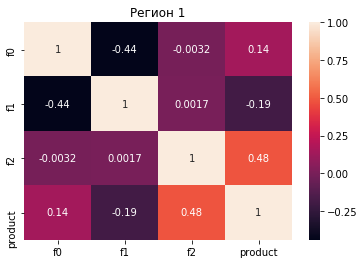

Text(0.5, 1, 'Регион 2')

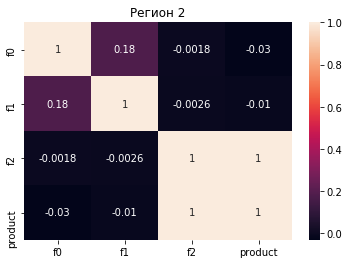

Text(0.5, 1, 'Регион 3')

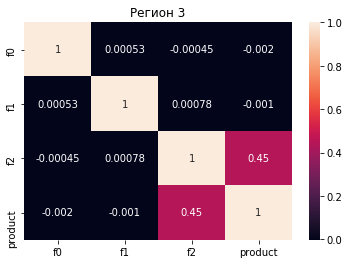

In [110]:
correlation_mat1 = df_1.corr()
correlation_mat2 = df_2.corr()
correlation_mat3 = df_3.corr()
sns.heatmap(correlation_mat1, annot = True)
plt.title("Регион 1")
plt.show()

sns.heatmap(correlation_mat2, annot = True)
plt.title("Регион 2")
plt.show()

sns.heatmap(correlation_mat3, annot = True)
plt.title("Регион 3")
plt.show()

### Вывод
В 1 и 3 регионах определены самые высокие (примерно одинаковые между собой) средние запасы сырья: 38 и 40 тыс. баррелей соответственно,

однако нужно отметить что наименьшее значение метрики RMSE определено на данных региона 2 (оно близко к нулю, что говорит нам о наивысшей точности предсказания), где наблюдается самое низкое значение среднего запаса сырья в 69 тыс. баррелей (малая ошибка у региона 2 - следствие высокой корреляции f2 с целевой),

а RMSE по регионам 1 и 3 примерно одинаково высока (около 40), что заставляет сомневаться в точности предсказаний по ним

## Подготовка к расчёту прибыли

Подготовим константы для расчёта прибыли:
* запишем в переменную all_budget весь бюджет (10 млрд руб) в тыс руб 
* в barrel_income - доход от продажи одного барреля = 450 р (а от 1 тыс баррелей - 450 тыс руб)
* в budget - бюджет на 1 скважину (т.к. нужно отобрать 200 лучших точек, разделим весь бюджет на 200)
* в admissible_product - достаточный объём сырья для безубыточной разработки новой скважины (рассчитаем как отношение бюджета на освоение одной скважины к доходу с одной тыс баррелей)

In [111]:
all_budget = 10**7
print('Весь бюджет: {} тыс руб'.format(all_budget))

barrel_income = 450
print('Доход от одной тысячи баррелей: {} тыс руб'.format(barrel_income))

budget = all_budget / 200
print('Бюджет на 1 скважину: {} тыс руб'.format(budget))

admissible_product = budget / barrel_income 
print('Достаточный объём сырья для безубыточной разработки новой скважины: {} тыс баррелей'\
      .format(admissible_product))

Весь бюджет: 10000000 тыс руб
Доход от одной тысячи баррелей: 450 тыс руб
Бюджет на 1 скважину: 50000.0 тыс руб
Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111 тыс баррелей


Сравним полученный объём сырья со средним запасом в каждом регионе

In [112]:
mean_1 = target1.mean()
mean_2 = target2.mean()
mean_3 = target3.mean()

print("Средний запас сырья:")
print('регион 1:', mean_1)
print('регион 2:', mean_2)
print('регион 3:', mean_3)

Средний запас сырья:
регион 1: 92.50000000000001
регион 2: 68.82500000000002
регион 3: 95.00000000000004


In [113]:
max_1 = target1.max()
max_2 = target2.max()
max_3 = target3.max()

print("Максимальный запас сырья в скважине:")
print('регион 1:', max_1)
print('регион 2:', max_2)
print('регион 3:', max_3)

Максимальный запас сырья в скважине:
регион 1: 185.3643474222929
регион 2: 137.94540774090564
регион 3: 190.02983834335132


In [114]:
print("Количество измерений в скважинах с запасом сырья, удовлетворяющим требованиям:")
print("регион 1:", target1[target1 > admissible_product].count())
print("регион 2:", target2[target2 > admissible_product].count())
print("регион 3:", target3[target3 > admissible_product].count())

Количество измерений в скважинах с запасом сырья, удовлетворяющим требованиям:
регион 1: 36583
регион 2: 16537
регион 3: 38178


### Вывод
Средние запасы сырья в скважинах по каждому региону оказались меньше чем достаточный объём сырья для безубыточной разработки новой скважины (примерно 111,2 тыс баррелей), что говорит нам о том что большая часть скважин нам не подойдет и необходимо будет осваивать только те скважины, что содержат запасов в диапазоне от 111,2 тыс баррелей до максимального показателя запаса сырья в регионе. 

Таких скважин намного больше двухсот по каждому региону,  
но в 1 и 3 регионах максимальные показатели запасов сильно выше чем во 2 регионе (190 и 185 против 138), что означает потенциально бОльший доход от них

## Расчёт прибыли и рисков 

Выберем скважины с максимальными значениями предсказаний:

In [115]:
print("Максимальный запас пердсказанного сырья:")
print('регион 1:', predicted_valid1.max())
print('регион 2:', predicted_valid2.max())
print('регион 3:', predicted_valid3.max())

Максимальный запас пердсказанного сырья:
регион 1: 180.1807130612532
регион 2: 139.81896981252765
регион 3: 165.85683317435658


Лучший максимальный запас сырья в скважинах был предсказан в регионах 1 и 3 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
1. на вход она будет принимать таргет и предсказания целевого признака по одному региону
2. отсортирует предсказанные данные по убыванию
3. отберет из таргета count лучших значений по индексу из предсказаний 
4. посчитает объем сырья по этим значениям, просуммировав их
5. рассчитывает оборот от продажи всего посчитанного объема сырья по указанной в условии цене в 450 руб за 1 баррель (сохраняли в переменной barrel_income)
6. на выход отдаст предполагаемую прибыль (из оборота вычитаем вложения на освоение одного региона =  10 млрд руб - сохранено в переменной all_budget)

In [116]:
def profit(target, predicted, count):
    
    predict_sorted = pd.Series(predicted).sort_values(ascending=False)
    selected = target[predict_sorted.index][:count]
    
    revenue = selected.sum() * barrel_income
    profit_reg = revenue - all_budget
    
    return profit_reg

Посчитаем риски и прибыль для каждого региона:
1. Применим технику Bootstrap с 1000 повторений для того, чтобы найти распределение прибыли.
2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [172]:
predicted_valid1 = pd.Series(predicted_valid1)
predicted_valid2 = pd.Series(predicted_valid2)
predicted_valid3 = pd.Series(predicted_valid3)

state = np.random.RandomState(12345)

values1 = []
values2 = []
values3 = []

num=500

target1=target_valid1.reset_index(drop=True)
target2=target_valid2.reset_index(drop=True)
target3=target_valid3.reset_index(drop=True)


for i in range(1000):
    
    target_subsample1 = target1.sample(n=num, replace=True, random_state=state)
    predicted_subsample1 = predicted_valid1[target_subsample1.index]
    values1.append(profit(target_subsample1, predicted_subsample1, 200))
    
    target_subsample2 = target2.sample(n=num, replace=True, random_state=state)
    predicted_subsample2 = predicted_valid2[target_subsample2.index]
    values2.append(profit(target_subsample2, predicted_subsample2, 200))
    
    target_subsample3 = target3.sample(n=num, replace=True, random_state=state)
    predicted_subsample3 = predicted_valid3[target_subsample3.index]
    values3.append(profit(target_subsample3, predicted_subsample3, 200))

In [173]:
def calculate(values):
    lower = values.quantile(0.025)
    mean = values.mean()
    upper = values.quantile(0.975)
 #   loss = values[values<0].count() / 10
    loss = (values<0).mean()
    return lower,mean,upper,loss

In [174]:
resultAsTable = pd.DataFrame(data=[
    ('Регион 1',) + calculate(pd.Series(values1)),
    ('Регион 2',) + calculate(pd.Series(values2)),
    ('Регион 3',) + calculate(pd.Series(values3))
], columns = ['Регион', '2.5%-квантиль', 'Средняя прибыль', '97.5%-квантиль', 'Риск убытков'])

print(resultAsTable.to_string(index=False))

   Регион  2.5%-квантиль  Средняя прибыль  97.5%-квантиль  Риск убытков
 Регион 1 -123528.116449    414736.268614   968562.865496         0.070
 Регион 2   85329.746226    513172.169344   940106.288298         0.009
 Регион 3 -140423.727252    410198.401274   967716.156982         0.085


In [32]:
predicted_valid1 = pd.Series(predicted_valid1)
predicted_valid2 = pd.Series(predicted_valid2)
predicted_valid3 = pd.Series(predicted_valid3)

state = np.random.RandomState(12345)

values1 = []
values2 = []
values3 = []

for i in range(1000):
    
    target_subsample1 = predicted_valid1.sample(n=400, replace=True, random_state=state)
    predicted_subsample1 = predicted_valid1[target_subsample1.index]
    values1.append(profit(target_subsample1, predicted_subsample1, 200))
    
    target_subsample2 = predicted_valid2.sample(n=400, replace=True, random_state=state)
    predicted_subsample2 = predicted_valid2[target_subsample2.index]
    values2.append(profit(target_subsample2, predicted_subsample2, 200))
    
    target_subsample3 = predicted_valid3.sample(n=400, replace=True, random_state=state)
    predicted_subsample3 = predicted_valid3[target_subsample3.index]
    values3.append(profit(target_subsample3, predicted_subsample3, 200))
    
    
resultAsTable = pd.DataFrame(data=[
    ('Регион 1',) + calculate(pd.Series(values1)),
    ('Регион 2',) + calculate(pd.Series(values2)),
    ('Регион 3',) + calculate(pd.Series(values3))
], columns = ['Регион', '2.5%-квантиль', 'Средняя прибыль', '97.5%-квантиль', 'Риск убытков'])

print(resultAsTable.to_string(index=False))

   Регион  2.5%-квантиль  Средняя прибыль  97.5%-квантиль  Риск убытков
 Регион 1 -208029.904261     32076.374599   269616.132140          39.8
 Регион 2 -644506.554162   -163518.196888   223888.837012          75.8
 Регион 3 -208094.909502      4061.013571   220900.655888          47.7


In [29]:
predicted_valid1 = pd.Series(predicted_valid1)
predicted_valid2 = pd.Series(predicted_valid2)
predicted_valid3 = pd.Series(predicted_valid3)

state = np.random.RandomState(12345)

values1 = []
values2 = []
values3 = []

for i in range(1000):
    
    target_subsample1 = predicted_valid1.sample(n=600, replace=True, random_state=state)
    predicted_subsample1 = predicted_valid1[target_subsample1.index]
    values1.append(profit(target_subsample1, predicted_subsample1, 200))
    
    target_subsample2 = predicted_valid2.sample(n=600, replace=True, random_state=state)
    predicted_subsample2 = predicted_valid2[target_subsample2.index]
    values2.append(profit(target_subsample2, predicted_subsample2, 200))
    
    target_subsample3 = predicted_valid3.sample(n=600, replace=True, random_state=state)
    predicted_subsample3 = predicted_valid3[target_subsample3.index]
    values3.append(profit(target_subsample3, predicted_subsample3, 200))
    
    
resultAsTable = pd.DataFrame(data=[
    ('Регион 1',) + calculate(pd.Series(values1)),
    ('Регион 2',) + calculate(pd.Series(values2)),
    ('Регион 3',) + calculate(pd.Series(values3))
], columns = ['Регион', '2.5%-квантиль', 'Средняя прибыль', '97.5%-квантиль', 'Риск убытков'])

print(resultAsTable.to_string(index=False))

   Регион  2.5%-квантиль  Средняя прибыль  97.5%-квантиль  Риск убытков
 Регион 1  424546.684770     6.436915e+05    8.795409e+05           0.0
 Регион 2  676557.772758     1.062020e+06    1.353016e+06           0.0
 Регион 3  335143.061039     5.282063e+05    7.319419e+05           0.0


### Вывод

По итогу данного пункта, риск убытков у 2 и 3 регионов превысил допустимый порог в 2,5% (у них риски равны 8 и 3 % соответственно), и предсказанный риск убытков у первого региона как раз вписывается в требования (он равен 1%).

Также если рассматривать предсказанную потенциальную среднюю прибыль с освоения скважин в регионах, то лидируют регионы 1 и 2, а 3й находится в абсолютных аутсайдерах. 

На основании данных исследований **можно порекомендовать к освоению первый регион**, т.к. он вероятнее всего принесет наибольшую прибыль с наименьшими рисками убытков.